# Vortex Profile

This notebook shows
- how to fit a vortex profile obtained from LiDAR measurement
- how to calculate the circulation of the vortex

### Import libraries

In [1]:
import random
from math import pi, sqrt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

## Vortex models

There are several ways to model a 2D vortex. 

### Lamb-Oseen model

https://en.wikipedia.org/wiki/Lamb%E2%80%93Oseen_vortex

Here, we are interested in the form of the Lamb-Oseen model for wake vortices:

$V(r) = \frac{\Gamma} {2 {\pi}} (1 - exp(-1.256\frac{r^2}{r_c^2}))$

where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core or radial distance
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [2]:
def lamb_oseen(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = radial distance in m
    returns the tangential velocity
    """
    # Small manipulation to avoid the case r = 0 below 
    r_new = (r == 0).astype(int) / 1000 + r
    return gamma / (2 * pi * r_new) * (1 - np.exp( - 1.256 * r ** 2 / rc ** 2))

### Rankine model

https://en.wikipedia.org/wiki/Rankine_vortex

The drawback the rankine model is its non-linearity. Therefore it won't be used.

$V(r) = \frac{\Gamma r}{2 {\pi} r_c^2} $ for $r \le R $

$V(r) = \frac{\Gamma}{2 {\pi} r} $ if $ for > R $


where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core or radial distance
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [3]:
def rankine(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = radial distance in m
    returns the tangential velocity
    """
    internal_V = (abs(r) <= rc).astype(int) * gamma * r /( 2 * pi * rc**2)
    # Small manipulation to avoid the case r = 0 below 
    r_new = (r == 0).astype(int) / 1000 + r
    external_V = (abs(r) > rc).astype(int) * gamma / (2 * pi * r_new)
    return internal_V + external_V

### Burnham-Hallock model

The Burnham-Hallock model is widely used for aircraft wake vortices.

$V(r)=\frac{\Gamma}{2{\pi}r}\frac{r^2}{r^2+r_c^2}$

where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core  or radial distance
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [4]:
def burnham_hallock(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = radial distance in m
    returns the tangential velocity
    """
    return gamma / (2 * pi) * r / (r ** 2 + rc ** 2)

### Comparison of the models

Let's define a vortex with 300m^2/s total circulation and a core radius of 4m between -20m and 20m and plot the vortex profile

In [5]:
r_max = 20
r_min = -r_max
r_step = 0.5

total_circulation = 300
core_radius = 4

radial_distance = np.arange(r_min, r_max+r_step, r_step)

velocity_lo = lamb_oseen(total_circulation, core_radius, radial_distance)
velocity_ra = rankine(total_circulation, core_radius, radial_distance)
velocity_bh = burnham_hallock(total_circulation, core_radius, radial_distance)

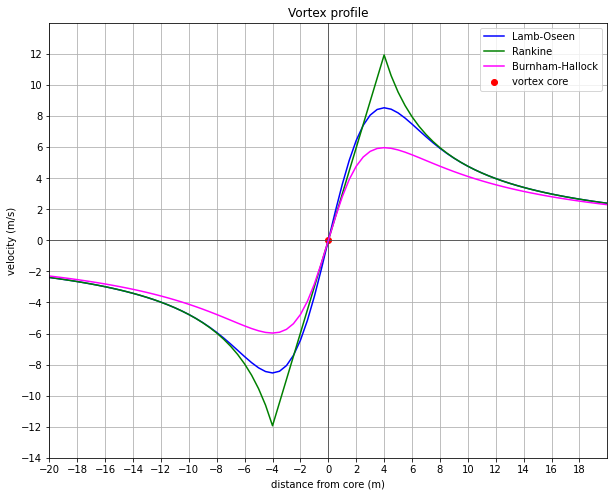

In [6]:
%matplotlib inline

y_max = int(max(np.max(velocity_lo), np.max(velocity_ra), np.max(velocity_bh)) / 2) * 2 + 4
x_max = r_max

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 2)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.plot(radial_distance, velocity_lo, color='blue', label='Lamb-Oseen')
ax.plot(radial_distance, velocity_ra, color='green', label='Rankine')
ax.plot(radial_distance, velocity_bh, color='magenta', label='Burnham-Hallock')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/comparison_of_vortex_profiles.png")
plt.legend()
plt.show()

## Reconstruction of a LiDAR envelope

The analysis of aircraft wake vortices is made using data provided by post-processing of LiDAR measurements. These data consist of envelopes of the measured tangential velocity as a function of the radial distance (distance from the position of the vortex core).

To make the data more realistic, following additional parameters must be added to the model equations:
- random background noise
- radial shift $\Delta r_c$
- tangential velocity shift $\Delta V$
- random error around the calculted profile $\delta \epsilon_V$

The measurements are discrete, that means, that we obtained points on the velocity profile at a regular interval, the so-called LiDAR resolution.

In [7]:
def add_noise_to_envelope(velocity):
    """
    Add noise to the envelope.
    Noise is assumed to be 2 m/s
    The envelope is crossing the y=0 only in the core
    """
    noise = np.random.normal(1, 0.25, velocity.shape) * np.sign(velocity)
    return np.maximum(np.abs(velocity), noise) * np.sign(velocity)

In [8]:
def add_shift():
    """
    Returns two random numbers for radial and velocity shift
    """
    return random.gauss(0, 0.25), random.gauss(0, 0.25)

In [9]:
def add_random_error(velocity):
    """
    Add random error to the velocity profile
    An error of +/- 0.5 m/s is added to the profile
    """
    return velocity + np.random.normal(0, 0.25, velocity.shape)

In [10]:
def generate_lidar_envelope(Gamma, rc, r, model=burnham_hallock):
    """
    Return the full vortex profile including noice, shifts and error
    """
    Delta_r, Delta_V = add_shift()
    # radial shift
    r -= Delta_r
    # Velocity profile
    velocity_profile = model(Gamma, rc, r)
    # add the noise
    velocity_profile = add_noise_to_envelope(velocity_profile)
    # add the random_error
    velocity_profile = add_random_error(velocity_profile)
    # Tangential velocity shift
    return velocity_profile + Delta_V, Delta_r, Delta_V

In [11]:
def set_lidar_resolution():
    """
    Return the lidar resolution, i.e. the average radial distance between two data points
    """
    return random.uniform(1, 3)

Let's define a vortex with 300m^2/s total circulation and a core radius of 3m between -100m and 100m and plot the vortex profile with the LiDAR envelope.

For this exercise, we use a Burnham-Hallock profile.

In [12]:
r_max = 100
r_min = -r_max
r_step = set_lidar_resolution()

total_circulation = 300
core_radius = 4

radial_distance = np.arange(r_min, r_max+r_step, r_step)
radial_distance_model = np.arange(r_min, r_max+1, 0.5)

velocity_lidar, Delta_r, Delta_V = generate_lidar_envelope(total_circulation, core_radius, radial_distance)
velocity_model = burnham_hallock(total_circulation, core_radius, radial_distance_model)

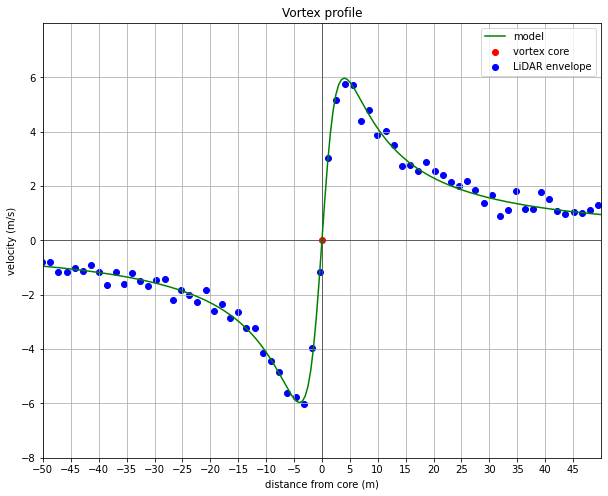

In [13]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='LiDAR envelope')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope.png")
plt.legend()
plt.show()

## Fitting of the LiDAR profile

The current step consists in doing the other way: from the reconstructed LiDAR profile, we will fit the data to estimate the original vortex characteristics

The adapted Burnham-Hallock model fitting the reconstructed data or the vortex profile data obtained from the LiDAR processing looks like:

$V(r)=\frac{\Gamma}{2{\pi}(r-\Delta r_c)}\frac{(r-\Delta r_c)^2}{(r-\Delta r_c)^2+r_c^2} + \Delta V$ 

Therefore, there are 4 unknown for this equation:
- $\Gamma$, the total circulation of the vortex
- $r_c$, the core radius of the vortex
- $\Delta r_c$, the radial shift
- $\Delta V$, the velocity shift

### First estimation of the velocity peaks
The positions of the peak velocities are read from the LiDAR profile.

In [14]:
def get_min_max_index(velocity_lidar):
    """
    Return the indices of the peak velocities
    """
    return np.argmin(velocity_lidar), np.argmax(velocity_lidar)

In [15]:
def get_min_max_radii(radial_distance, velocity_lidar):
    """
    Return the distance from the vortex core (r=0) for the peak velocities
    """
    idx_min, idx_max = get_min_max_index(velocity_lidar)
    return distance_from_core[idx_min], radial_distance[idx_max]

In [16]:
def get_min_max_velocity(velocity_lidar):
    """
    Return the values of the peak velocities
    """
    return np.min(velocity_lidar), np.max(velocity_lidar)

### Estimation of the mean tangential velocities
The mean tangential velocity is the mean of the absolute velocity.

Positive and negative mean tangential velocities outside the vortex core are calculated separately.

In [17]:
def get_abs_mean_velocity(velocity_lidar):
    """
    Return the average of absolute tangential velocities of the vortex profile
    """
    return np.mean(np.abs(velocity_lidar))

In [18]:
def get_neg_pos_mean_velocities(velocity_lidar):
    """
    Return the average of tangential velocities of the negative and positive vortex sides separately
    """
    idx_min, idx_max = get_min_max_index(velocity_lidar)
    return np.mean(velocity_lidar[:idx_min+1]), np.mean(velocity_lidar[idx_max:])

### Dismissing of outliers
#### Noise - Cuf-off
First, points far from the core are not to be separated from the noise. A cut-off is introduced under the following assumptions:
- Only a small of number of points is measured around the core,
- Their tangential velocities are bigger than the noise,
- In that case, the mean tangential velocity is slighty bigger than the noise,
- Every point under the mean velocity may therefore be considered as an outlier and has to be dismissed,
- To avoid an early cut-off due to a single outlier, there must be at least 3 points in a row under the mean velocity to locate the cut-off position.
- Points at the limit of the window are considered to be noise.

Second, points inside vortex core with tangential velocity smaller than the mean velocity are also dismissed as noise.

This method is used for positive and negative velocities separately.

In [19]:
def selection_of_points(velocity_lidar):
    """
    Return the selected points for the data fitting
    """
    v_neg_mean, v_pos_mean = get_neg_pos_mean_velocities(velocity_lidar)
    idx_min, idx_max = get_min_max_index(velocity_lidar)
    
    selected_neg_points = np.append(np.zeros(1), [(velocity_lidar[i-1] <= v_neg_mean).astype(int) +
                                                  (velocity_lidar[i] <= v_neg_mean).astype(int) + 
                                                  (velocity_lidar[i+1] <= v_neg_mean).astype(int) 
                                                  for i in range(1, len(velocity_lidar)-1)])
    selected_neg_points = np.append(selected_neg_points, np.zeros(1))
    
    selected_pos_points = np.append(np.zeros(1), [(velocity_lidar[i-1] >= v_pos_mean).astype(int) +
                                                  (velocity_lidar[i] >= v_pos_mean).astype(int) + 
                                                  (velocity_lidar[i+1] >= v_pos_mean).astype(int) 
                                                  for i in range(1, len(velocity_lidar)-1)])
    selected_pos_points = np.append(selected_pos_points, np.zeros(1))
    
    # Selected points in the vortex core
    selected_core_points = np.concatenate((np.ones(idx_min), 
                                           np.abs(velocity_lidar[idx_min:idx_max]) >= 
                                               0.5 * (v_pos_mean - v_neg_mean), 
                                           np.ones(velocity_lidar.shape - idx_max)))
    
    return (selected_neg_points + selected_pos_points) * selected_core_points
    # return 1

In [20]:
def dismiss_values_from_profile(vector, selected_points, velocity_lidar):
    """
    Return a reduced vector containing only data points used for the fitting
    """
    idx_min, idx_max = get_min_max_index(velocity_lidar)
    idx_core = np.where(selected_points[idx_min:idx_max] == 0)
    
    idx_start = np.where(selected_points[:idx_min] == 0)[0][-1]
    idx_end = np.where(selected_points[idx_max:] == 0)[0][0] + idx_max

    if idx_core[0].size == 0:
        return vector[idx_start:idx_end+1]
    
    idx_core_min = idx_core[0][0] + idx_min
    idx_core_max = idx_core[0][-1] + idx_min
    
    return np.concatenate((vector[idx_start:idx_core_min], vector[idx_core_max+1:idx_end+1]))

In [21]:
selected_points = selection_of_points(velocity_lidar)
print(selected_points)


distance_for_fitting = dismiss_values_from_profile(radial_distance, selected_points, velocity_lidar)
velocity_for_fitting = dismiss_values_from_profile(velocity_lidar, selected_points, velocity_lidar)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 2. 1. 2. 2. 3.
 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 0. 2. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]


In [22]:
v_neg_mean, v_pos_mean = get_neg_pos_mean_velocities(velocity_lidar)

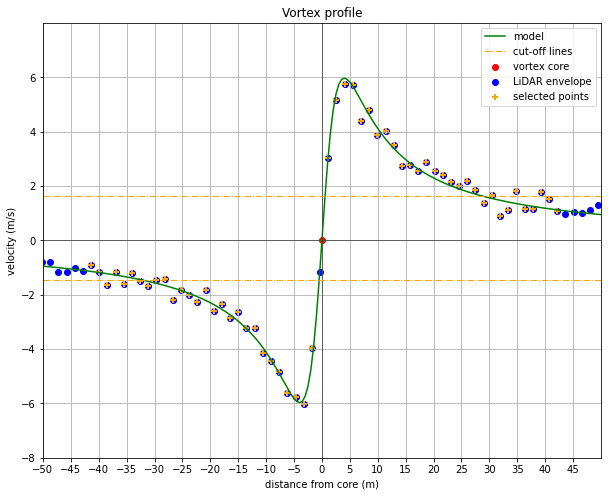

In [23]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='LiDAR envelope')
ax.scatter(distance_for_fitting, velocity_for_fitting, marker='+', color='orange', \
           lw=2, label='selected points')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')

plt.axhline(v_neg_mean, color='orange', lw=1, ls='-.', label='cut-off lines')
plt.axhline(v_pos_mean, color='orange', lw=1, ls='-.')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope_with_selected_points.png")
plt.legend()
plt.show()

### Definition of the profile function

In [24]:
def modified_burnham_hallock(r, gamma, rc, delta_r, delta_V):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = radial distance in m
    delta_r = radial shift in m
    delta_V = tangential velocity shift in m/s
    returns the tangential velocity using the modified Burnham-Hallock model
    """
    return gamma / (2 * pi) * (r - delta_r) / ( (r - delta_r )** 2 + rc**2) + delta_V

### Fit the LiDAR profile with the built-in function curve_fit

In [25]:
fitted_values, pcov = curve_fit(modified_burnham_hallock, 
                                distance_for_fitting, 
                                velocity_for_fitting, 
                                p0 = [100,1,0,0])

#### Comparison of results with initial data

In [26]:
original_values = [total_circulation, core_radius, Delta_r, Delta_V]

comparison_table = pd.DataFrame({'Original': original_values, 'Fit': fitted_values, 
                                 'Error': original_values - fitted_values,
                                 'Rel. error': 100 * (original_values - fitted_values) / original_values},
                                index=['Total circulation', 'Core radius', 'Delta_r', 'Delta_V'])

In [27]:
comparison_table.round(2)

,Original,Fit,Error,Rel. error
Total circulation,300.00,304.45,-4.45,-1.48
Core radius,4.00,4.17,-0.17,-4.31
Delta_r,0.01,-0.06,0.07,726.09
Delta_V,0.05,0.02,0.03,68.97


Based on these original values, core radius and total circulation are well estimated.

In [28]:
def root_mean_square_error(velocity_for_fitting, velocity_from_fitting):
    """
    Return the root-mean-square error of the fit
    """
    return sqrt(mean_squared_error(velocity_for_fitting, velocity_from_fitting))

In [29]:
velocity_from_fitting = modified_burnham_hallock(distance_for_fitting, 
                                                 total_circulation, 
                                                 core_radius, 
                                                 Delta_r, Delta_V)

RMSE = root_mean_square_error(velocity_for_fitting, velocity_from_fitting)

print(f"The root-mean-square error is {RMSE:0.3f} m/s")

The root-mean-square error is 0.279 m/s


In [30]:
velocity_from_fitting = modified_burnham_hallock(radial_distance_model, 
                                                 total_circulation, 
                                                 core_radius, 
                                                 Delta_r, Delta_V)

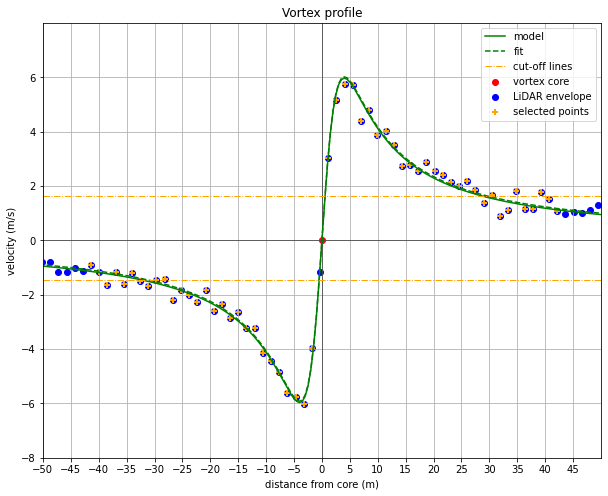

In [31]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='LiDAR envelope')
ax.scatter(distance_for_fitting, velocity_for_fitting, marker='+', color='orange', \
           lw=2, label='selected points')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')
ax.plot(radial_distance_model, velocity_from_fitting, color='green', ls='--', label='fit')

plt.axhline(v_neg_mean, color='orange', lw=1, ls='-.', label='cut-off lines')
plt.axhline(v_pos_mean, color='orange', lw=1, ls='-.')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope_with_fit.png")
plt.legend()
plt.show()

## Circulation between 5 to 15m
The circulation of a single vortex as a function of radial distance from the vortex center can be defined in terms of the tangential velocity